In [55]:
# necessary imports
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")
import wrangle as wra
import env
import explore as exp
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

In [2]:
zillow_query = """
        select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt,
        taxamount, fips
        from properties_2017
        where propertylandusetypeid = '261';
        """

zillow_df = wra.get_zillow_data(zillow_query)

zillow_df.head()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
df = zillow_df

In [4]:
df = wra.wrangle_zillow(df)

In [5]:
df.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
4,4,2.0,3633,296425,2005,6941.39,LA
6,3,4.0,1620,847770,2011,10244.94,LA
7,3,2.0,2077,646760,1926,7924.68,LA
11,0,0.0,1200,5328,1972,91.60,LA
14,0,0.0,171,6920,1973,255.17,LA


In [6]:
train, validate, test = wra.split_data(df)

In [7]:
print (f'''{train.shape}
{validate.shape}
{test.shape}''')

(1219902, 7)
(406635, 7)
(406635, 7)


# Exploration

### 1. As with encoded vs. unencoded data, we recommend exploring un-scaled data in your EDA process.

### 2. Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

### 3. Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

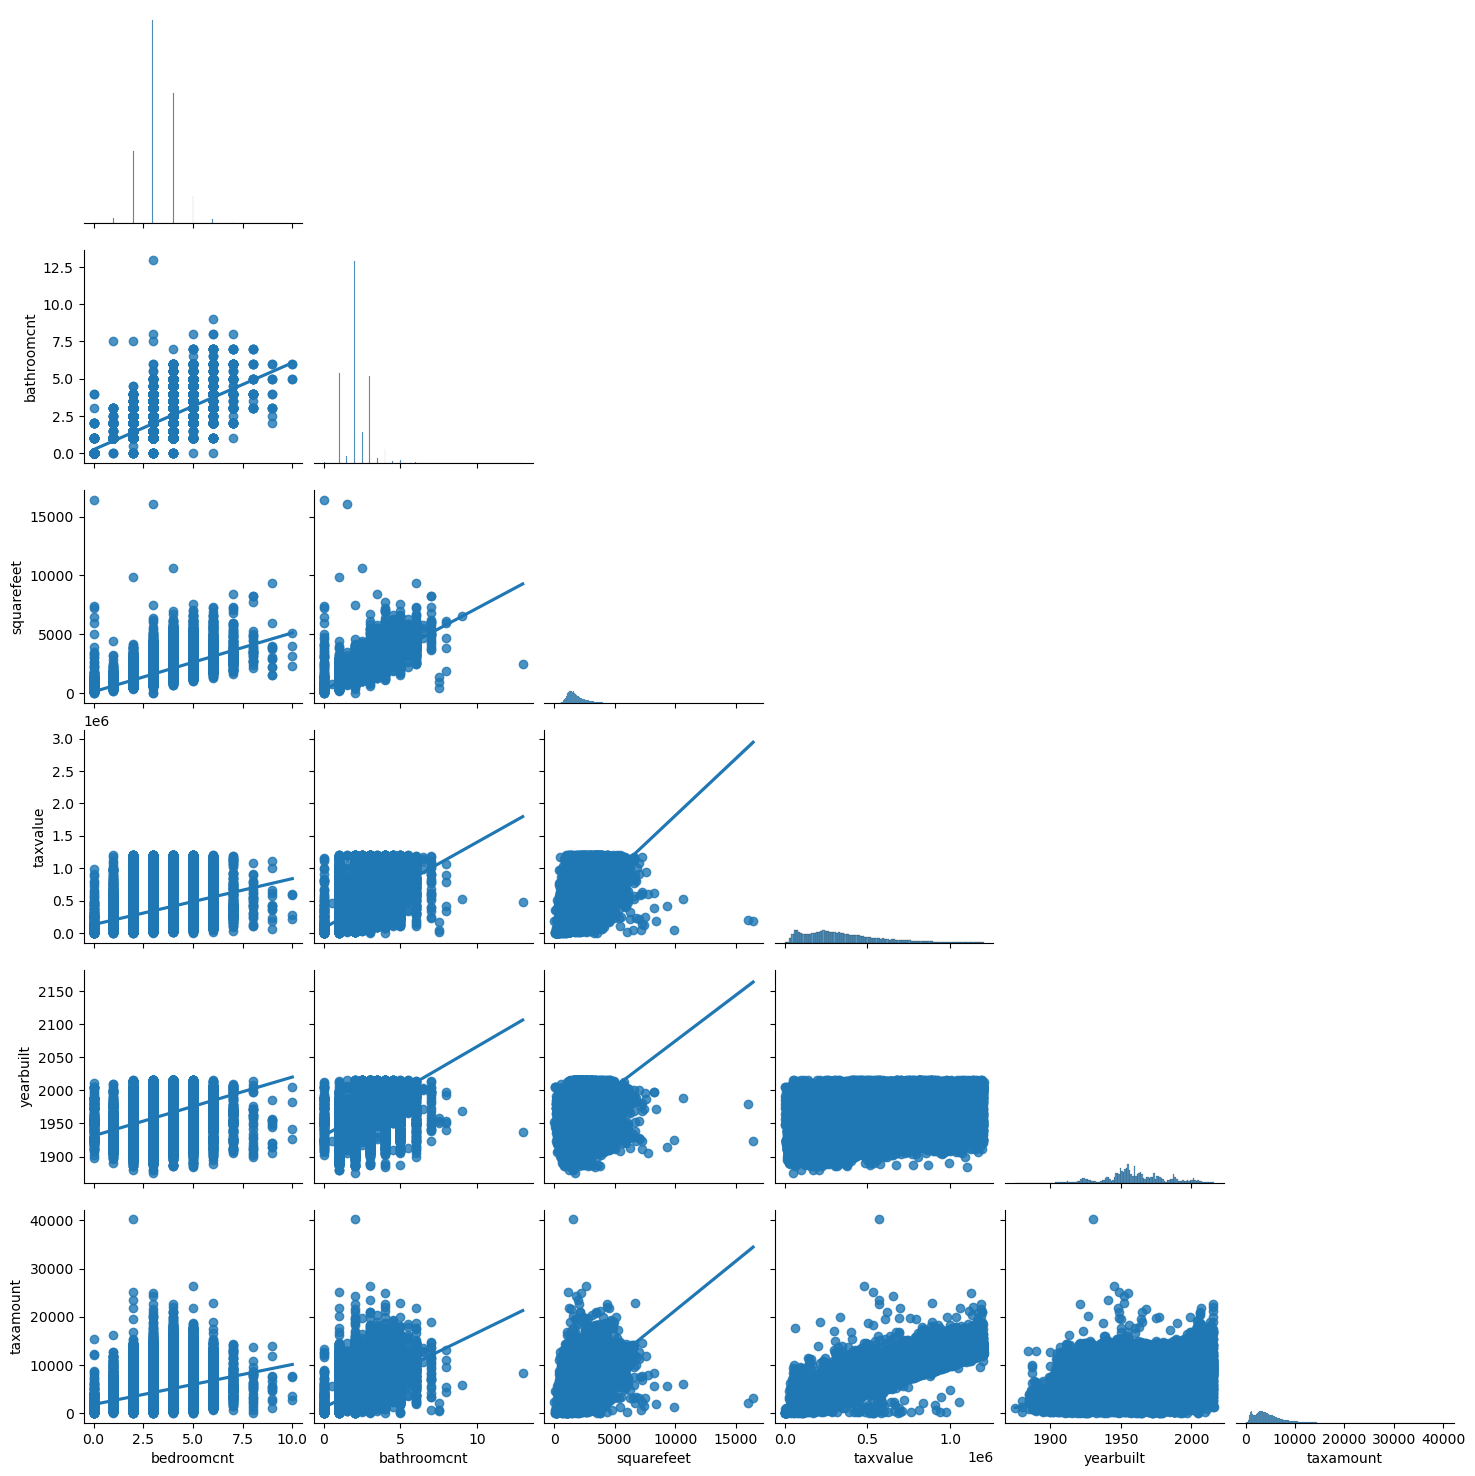

In [8]:
exp.plot_variable_pairs(train)

### 4. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

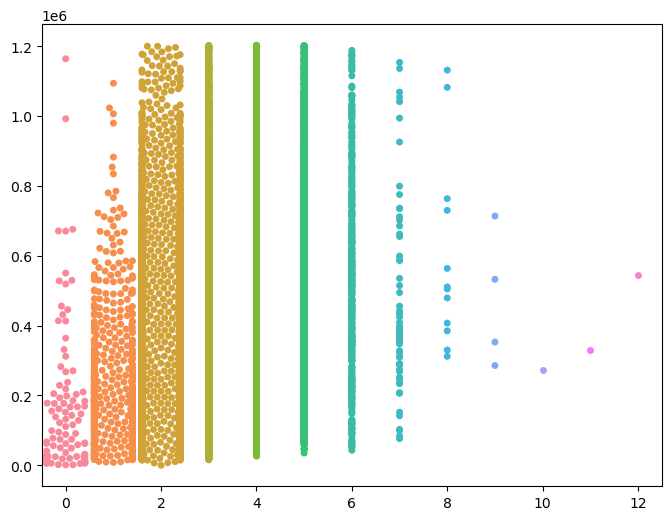

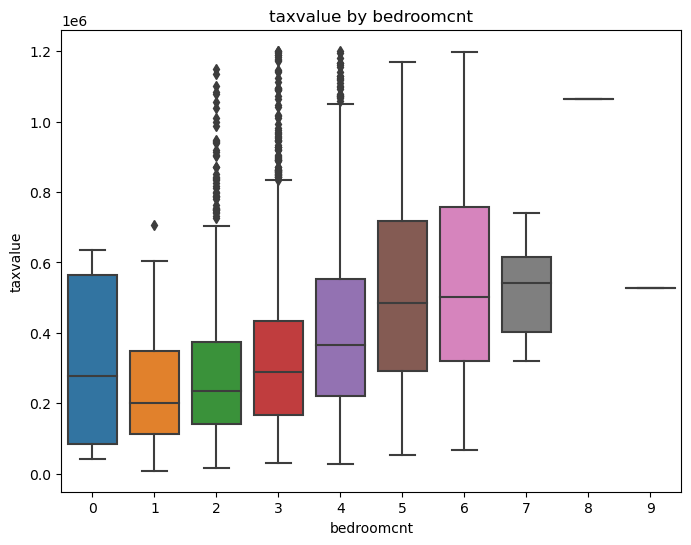

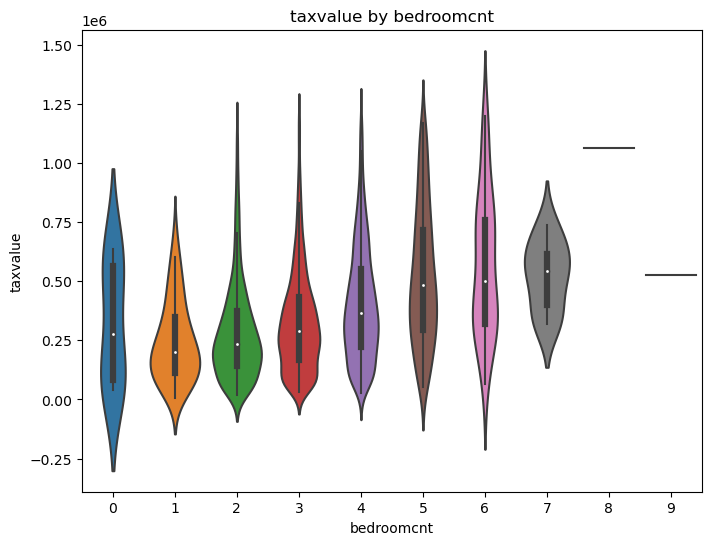

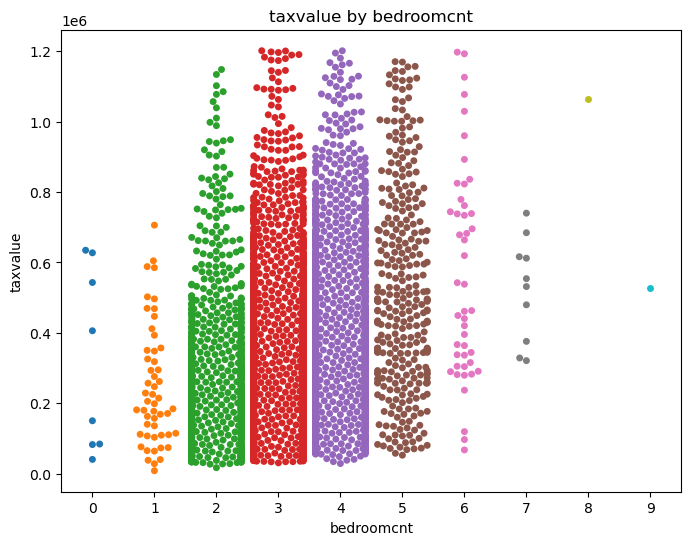

In [11]:
exp.plot_categorical_and_continuous_vars(train.sample(5000), 'taxvalue', 'bedroomcnt')

### 5. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

### 7. Come up with some initial hypotheses based on your goal of predicting property value.

* Is there a relationship between taxvalue and squarefeet?
* H0 = There is no linear correlation between taxvalue and squarefeet
* Ha = There is a correlation between taxvalue and squarefeet

### 8. Visualize all combinations of variables in some way

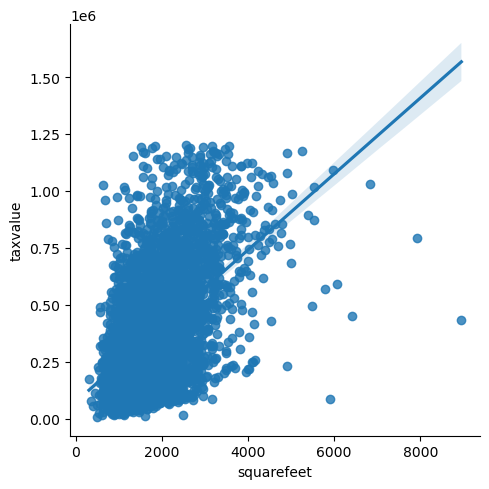

In [22]:
train_sample = train.sample(n=500, random_state=42)
sns.lmplot(x='squarefeet', y='taxvalue', data=train.sample(5000))
plt.show()

<Figure size 1800x1000 with 0 Axes>

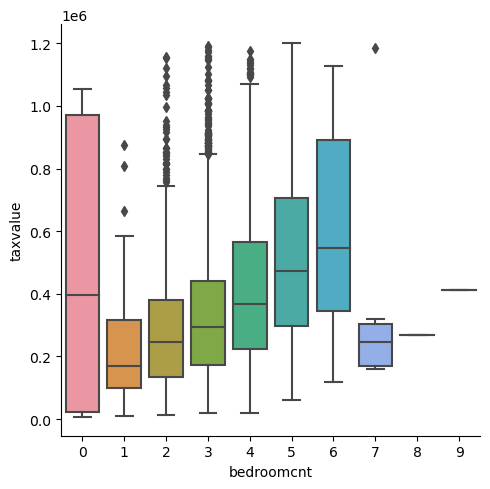

In [46]:
plt.figure(figsize=(18, 10))
train_sample2 = train.sample(n=5000, random_state=42)
sns.catplot(x='bedroomcnt', y='taxvalue', data=train_sample2, kind='box')
plt.show()

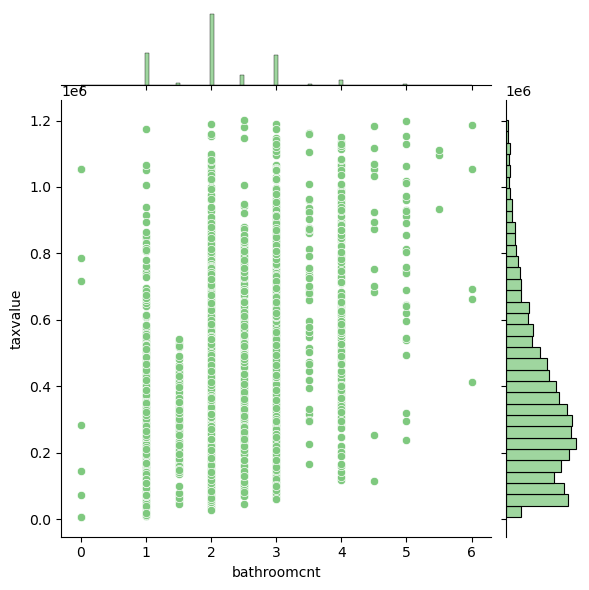

In [47]:
# Sample 2000 rows from the train dataset
train_sample3 = train.sample(n=5000, random_state=42)

# Set the color palette to greens and yellows
sns.set_palette(sns.color_palette(["#7fc97f", "#fcd87f"]))

# Create the jointplot with green and yellow colors
sns.jointplot(x='bathroomcnt', y='taxvalue', data=train_sample3)

# Display the plot
plt.show()

In [28]:
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
1571798,4,2.5,2987,885000,2006,13617.38,Orange
1723553,3,2.0,3013,489511,1977,5768.57,LA
718174,4,3.0,2572,390915,1986,4944.11,LA
1663205,3,1.0,1589,321758,1959,4031.78,LA
1087891,3,2.0,1727,231737,1962,2708.80,Ventura


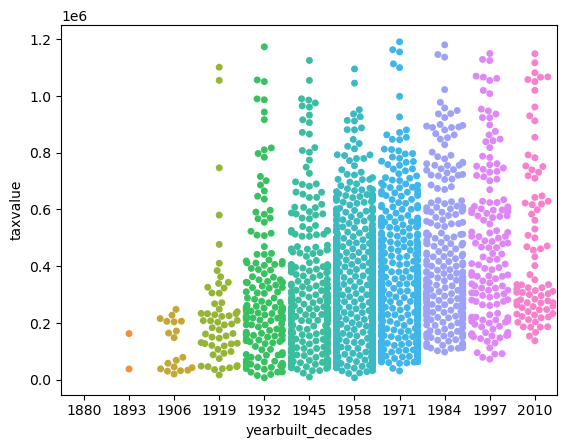

In [45]:
train_sample4 = train.sample(n=2000, random_state=42)

# Bin the 'yearbuilt' by decades
train_sample4['yearbuilt_decades'] = pd.cut(train_sample4['yearbuilt'], bins=np.arange(1870, 2020, 13), labels=np.arange(1880, 2020, 13))

# Create the swarmplot with the binned 'yearbuilt' column
sns.swarmplot(x='yearbuilt_decades', y='taxvalue', data=train_sample4)

# Display the plot
plt.show()

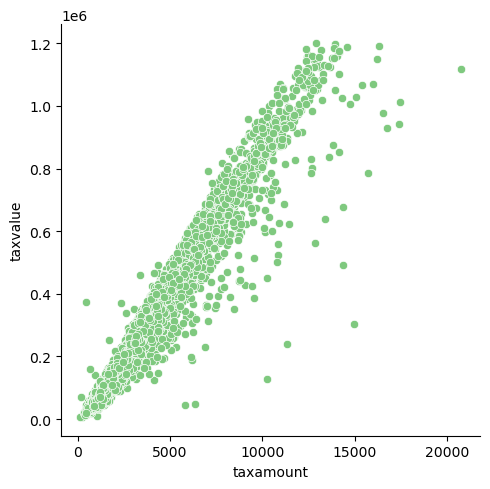

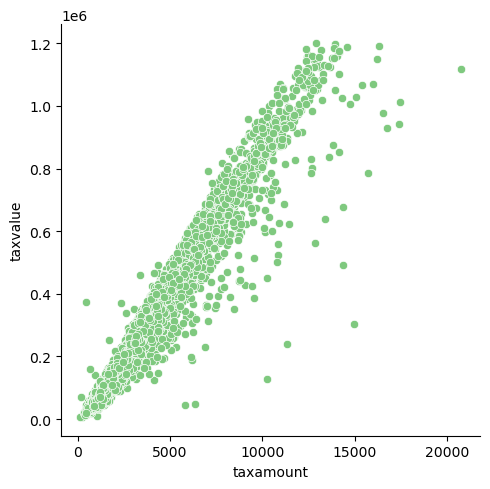

In [49]:
# Sample 5000 rows from the train dataset
train_sample5 = train.sample(n=5000, random_state=42)

# Create the relplot
sns.relplot(x='taxamount', y='taxvalue', data=train_sample5)
plt.show()

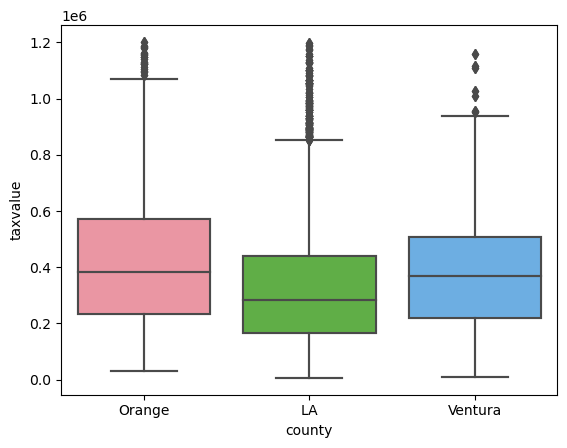

In [51]:
# Sample 5000 rows from the train dataset
train_sample6 = train.sample(n=5000, random_state=42)

# Create the boxplot
sns.boxplot(x='county', y='taxvalue', data=train_sample6)
plt.show()

### 9. Run the appropriate statistical tests where needed.

In [54]:
# Calculate the correlation coefficient and p-value
corr, p_value = pearsonr(train['squarefeet'], train['taxvalue'])

# Print the results
print("Correlation coefficient:", corr)
print("P-value:", p_value)

Correlation coefficient: 0.5231563189063831
P-value: 0.0


In [61]:
# Set the square footage threshold
threshold = 5000

# Create a new column that indicates whether each observation has a square footage greater than the threshold
train['squarefeet_binary'] = train['squarefeet'] > threshold

# Convert the binary column to a boolean type
train['squarefeet_binary'] = train['squarefeet_binary'].astype(bool)

# Calculate the point-biserial correlation coefficient and p-value
corr, p_value = pointbiserialr(train['squarefeet_binary'], train['taxvalue'])

# Print the results
print("Point-biserial correlation coefficient:", corr)
print("P-value:", p_value)

Point-biserial correlation coefficient: 0.09223631268933617
P-value: 0.0


In [71]:
# Convert the 'bedroomcnt' column to categorical
train['bedroomcnt'] = train['bedroomcnt'].astype(str)

# Perform the ANOVA test
result = stat.f_oneway(train[train['bedroomcnt'] == '0']['taxvalue'], 
                         train[train['bedroomcnt'] == '1']['taxvalue'], 
                         train[train['bedroomcnt'] == '2']['taxvalue'], 
                         train[train['bedroomcnt'] == '3']['taxvalue'], 
                         train[train['bedroomcnt'] == '4']['taxvalue'], 
                         train[train['bedroomcnt'] == '5']['taxvalue'], 
                         train[train['bedroomcnt'] == '6']['taxvalue'], 
                         train[train['bedroomcnt'] == '7']['taxvalue'], 
                         train[train['bedroomcnt'] == '8']['taxvalue'], 
                         train[train['bedroomcnt'] == '9']['taxvalue'])

# Print the results
print("F-statistic:", result[0])
print("P-value:", result[1])

F-statistic: 10394.716659001142
P-value: 0.0


In [74]:
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county,squarefeet_binary
1571798,4,2.5,2987,885000,2006,13617.38,Orange,False
1723553,3,2.0,3013,489511,1977,5768.57,LA,False
718174,4,3.0,2572,390915,1986,4944.11,LA,False
1663205,3,1.0,1589,321758,1959,4031.78,LA,False
1087891,3,2.0,1727,231737,1962,2708.80,Ventura,False


In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1219902 entries, 1571798 to 1587454
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   bedroomcnt         1219902 non-null  object 
 1   bathroomcnt        1219902 non-null  float64
 2   squarefeet         1219902 non-null  int64  
 3   taxvalue           1219902 non-null  int64  
 4   yearbuilt          1219902 non-null  int64  
 5   taxamount          1219902 non-null  float64
 6   county             1219902 non-null  object 
 7   squarefeet_binary  1219902 non-null  bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 75.6+ MB


### 10. What independent variables are correlated with the dependent variable, home value?


In [83]:
# Calculate the correlation matrix
corr_matrix = train[['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount', 'taxvalue']].corr()

# Get the correlation coefficients of the independent variables with the dependent variable
corr_with_taxvalue = corr_matrix['taxvalue'][['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount']]

# Print the correlation coefficients in descending order
print(corr_with_taxvalue.sort_values(ascending=False))

KeyError: "['bedroomcnt'] not in index"